<a href="https://colab.research.google.com/github/HannaPo/ML-zoomcamp/blob/master/03_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [2]:
data = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"

In [3]:
!wget $data -O cars_03.csv

--2023-10-02 11:12:39--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘cars_03.csv’

cars_03.csv         100%[===================>]   1.41M  --.-KB/s    in 0.07s   

2023-10-02 11:12:39 (19.1 MB/s) - ‘cars_03.csv’ saved [1475504/1475504]



In [4]:
df = pd.read_csv('cars_03.csv')
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


**Data preparation**

In [5]:
df.rename(columns={'MSRP': 'price'}, inplace=True)

In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [7]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
price                   0
dtype: int64

In [8]:
columns_to_fill = ["engine_fuel_type", "engine_hp", "engine_cylinders", "number_of_doors", "market_category"]
df[columns_to_fill] = df[columns_to_fill].fillna(0)
df.isnull().sum()

make                 0
model                0
year                 0
engine_fuel_type     0
engine_hp            0
engine_cylinders     0
transmission_type    0
driven_wheels        0
number_of_doors      0
market_category      0
vehicle_size         0
vehicle_style        0
highway_mpg          0
city_mpg             0
popularity           0
price                0
dtype: int64

In [9]:
df_selected = df.copy()
selected_cols = ['make', 'model', 'year', 'engine_hp',
       'engine_cylinders', 'transmission_type', 'vehicle_style',
       'highway_mpg', 'city_mpg', 'price']
df_selected = df_selected[selected_cols]


In [10]:
df_selected.head().T

,0,1,2,3,4
make,bmw,bmw,bmw,bmw,bmw
model,1_series_m,1_series,1_series,1_series,1_series
year,2011,2011,2011,2011,2011
engine_hp,335.0,300.0,300.0,230.0,230.0
engine_cylinders,6.0,6.0,6.0,6.0,6.0
transmission_type,manual,manual,manual,manual,manual
vehicle_style,coupe,convertible,coupe,coupe,convertible
highway_mpg,26,28,28,28,28
city_mpg,19,19,20,18,18
price,46135,40650,36350,29450,34500


**Question 1: What is the most frequent observation (mode) for the column transmission_type?**

In [11]:
df_selected.transmission_type.value_counts()

automatic           8266
manual              2935
automated_manual     626
direct_drive          68
unknown               19
Name: transmission_type, dtype: int64

**Question 2: What are the two features that have the biggest correlation in this dataset?**

In [12]:
df_selected.corr()

<ipython-input-12-44b33cd41713>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_selected.corr()


,year,engine_hp,engine_cylinders,highway_mpg,city_mpg,price
year,1.000000,0.338714,-0.040708,0.258240,0.198171,0.227590
engine_hp,0.338714,1.000000,0.774851,-0.415707,-0.424918,0.650095
engine_cylinders,-0.040708,0.774851,1.000000,-0.614541,-0.587306,0.526274
highway_mpg,0.258240,-0.415707,-0.614541,1.000000,0.886829,-0.160043
city_mpg,0.198171,-0.424918,-0.587306,0.886829,1.000000,-0.157676
price,0.227590,0.650095,0.526274,-0.160043,-0.157676,1.000000


<ipython-input-13-180186422296>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_selected.corr(),annot=True,linewidths=.4, cmap="Blues")


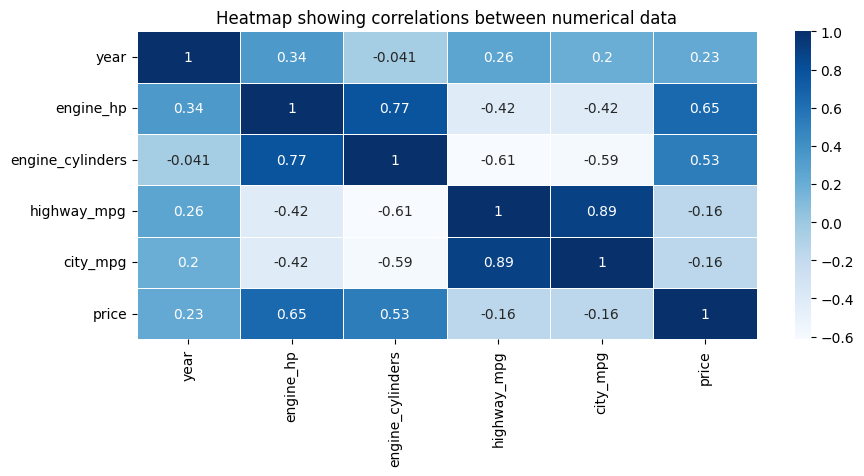

In [13]:
plt.figure(figsize=(10,4))
sns.heatmap(df_selected.corr(),annot=True,linewidths=.4, cmap="Blues")
plt.title('Heatmap showing correlations between numerical data')
plt.show()

In [14]:
df_selected.corr().unstack().sort_values(ascending = False)[:10]

<ipython-input-14-b8b620864614>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_selected.corr().unstack().sort_values(ascending = False)[:10]


year              year                1.000000
engine_hp         engine_hp           1.000000
city_mpg          city_mpg            1.000000
highway_mpg       highway_mpg         1.000000
engine_cylinders  engine_cylinders    1.000000
price             price               1.000000
city_mpg          highway_mpg         0.886829
highway_mpg       city_mpg            0.886829
engine_hp         engine_cylinders    0.774851
engine_cylinders  engine_hp           0.774851
dtype: float64

**The biggest correlation is for highway_mpg and city_mpg = 0.886829**

**Question 3: Feature with the lowest mutual information score?**

In [15]:
data_class = df.copy()
mean_price = data_class['price'].mean()

data_class['above_average'] = np.where(data_class['price'] >= mean_price, 1 , 0)

In [16]:
data_class = data_class.drop('price', axis=1)

In [17]:
df_full_train, df_test = train_test_split(data_class, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [18]:
len(df_train), len(df_val), len(df_test)

(7148, 2383, 2383)

In [19]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [20]:
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

In [21]:
df_full_train.above_average.value_counts(normalize=True)

0    0.723219
1    0.276781
Name: above_average, dtype: float64

In [22]:
mutual_info_score(df_full_train.above_average, df_full_train.make)

0.2387236479073192

In [23]:
categorical = [
   'make',
   'model',
   'transmission_type',
   'vehicle_style',
]

In [24]:
def mutual_info_above_average_score(series):
    return mutual_info_score(series, df_full_train.above_average)

In [25]:
mi = round(df_full_train[categorical].apply(mutual_info_above_average_score), 2)
mi.sort_values()

transmission_type    0.02
vehicle_style        0.08
make                 0.24
model                0.46
dtype: float64

 Feature with the lowest mutual information score: **transmission_type = 0.02**

**Question 4: Accuracy of the model**

In [26]:
numerical = ["year", "engine_hp", "engine_cylinders", "highway_mpg", "city_mpg"]

In [27]:
dv = DictVectorizer(sparse=False)
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [28]:
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

In [29]:
y_pred = model.predict_proba(X_val)[:, 1]
decision = (y_pred >= 0.5)

In [30]:
accuracy = round((y_val == decision).mean(), 2)
accuracy

0.95

**Question 5: Feature selection - the smallest difference in accuracy**

In [31]:
features = numerical + categorical
features

['year',
 'engine_hp',
 'engine_cylinders',
 'highway_mpg',
 'city_mpg',
 'make',
 'model',
 'transmission_type',
 'vehicle_style']

In [32]:
for c in features:
    subset = features.copy()
    subset.remove(c)

    train_dict = df_train[subset].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)

    X_train = dv.transform(train_dict)

    model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    val_dict = df_val[subset].to_dict(orient='records')
    X_val = dv.transform(val_dict)

    y_pred = model.predict(X_val)

    score = accuracy_score(y_val, y_pred)
    print(c, accuracy - score)


year 0.0016156105749055572
engine_hp 0.02721359630717579
engine_cylinders 0.0028745279060008455
highway_mpg 0.005812001678556444
city_mpg 0.01756189676877884
make 0.0016156105749055572
model 0.033927822073017144
transmission_type 0.004553084347461156
vehicle_style 0.01294586655476282


**Question 6: Regression with Scikit-Learn. What's the best alpha?**

In [33]:
df['price']=np.log1p(df['price'])

In [34]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)

In [35]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [36]:
y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

In [37]:
del df_train['price']
del df_val['price']
del df_test['price']

In [38]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [ ]:
for a in [0, 0.01, 0.1, 1, 10]:
    model = Ridge(alpha=a, solver="sag", random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    score = np.sqrt(mean_squared_error(y_val, y_pred))

    print(a, round(score, 3))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0 0.487
